In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

np.random.seed(42)

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read data from csv file into dataframe
df = pd.read_csv('GlobalLandTemperaturesByCity.csv')

# peak into data
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [3]:
# rename columnn
df.rename(columns={'dt':'date', 'AverageTemperature':'avg_temp', 'City':'city'},inplace=True)
df.head(1)

,date,avg_temp,AverageTemperatureUncertainty,city,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E


In [4]:
# check for data types
df.dtypes

date                              object
avg_temp                         float64
AverageTemperatureUncertainty    float64
city                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object

In [5]:
# convert data type; from object to datetime
df['date'] = pd.to_datetime(df['date'])

In [6]:
# check for data types
df.dtypes

date                             datetime64[ns]
avg_temp                                float64
AverageTemperatureUncertainty           float64
city                                     object
Country                                  object
Latitude                                 object
Longitude                                object
dtype: object

In [7]:
# set date to index
df = df.set_index('date').sort_index()

In [8]:
# peak into data
df.head()

,avg_temp,AverageTemperatureUncertainty,city,Country,Latitude,Longitude
date,,,,,,
1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1743-11-01,5.044,2.222,Pleven,Bulgaria,44.20N,24.60E
1743-11-01,4.635,1.711,Plock,Poland,52.24N,18.39E
1743-11-01,2.872,2.228,Ploiesti,Romania,45.81N,26.54E
1743-11-01,4.528,2.201,Plovdiv,Bulgaria,42.59N,24.00E


In [9]:
df = df[['city', 'avg_temp']]
df

,city,avg_temp
date,,
1743-11-01,Århus,6.068
1743-11-01,Pleven,5.044
1743-11-01,Plock,4.635
1743-11-01,Ploiesti,2.872
1743-11-01,Plovdiv,4.528
...,...,...
2013-09-01,Tabriz,NaN
2013-09-01,Guangyuan,NaN
2013-09-01,Guangshui,NaN


In [10]:
df = df[df['city']=='Plock']
df

,city,avg_temp
date,,
1743-11-01,Plock,4.635
1743-12-01,Plock,NaN
1744-01-01,Plock,NaN
1744-02-01,Plock,NaN
1744-03-01,Plock,NaN
...,...,...
2013-05-01,Plock,15.282
2013-06-01,Plock,18.086
2013-07-01,Plock,20.437


In [11]:
# check for null
df.isnull().sum()

city         0
avg_temp    73
dtype: int64

In [12]:
#  fill nul values with 0
df = df.fillna(method='ffill')

In [13]:
# check for null
df.isnull().sum()

city        0
avg_temp    0
dtype: int64

In [14]:
# resample dataframe to a year time period
df_resampled = df.resample('Y')[['avg_temp']].max()
df_resampled

,avg_temp
date,
1743-12-31,4.635
1744-12-31,17.932
1745-12-31,7.059
1746-12-31,7.059
1747-12-31,7.059
...,...
2009-12-31,20.125
2010-12-31,22.297
2011-12-31,19.431


In [15]:
# get length of dataframe
df_resampled.shape

(271, 1)

In [16]:
# set train to 50% of total
train_size = int(round(df_resampled.shape[0]* 0.5))
train_size

136

In [17]:
# set validate to 30% of total
validate_size = int(round(df_resampled.shape[0]* 0.3))
validate_size

81

In [18]:
# set test to to remaining of total which is 20 %
test_size = int(round(df_resampled.shape[0]* 0.2))
test_size

54

In [19]:
# validate will go from train_size + validate size
validate_end_index = train_size + validate_size
validate_end_index

217

In [20]:
# split into train, validate, test
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

#### check gap between train, validate and test

In [21]:
train.tail()

,avg_temp
date,
1874-12-31,20.411
1875-12-31,19.482
1876-12-31,19.103
1877-12-31,18.886
1878-12-31,18.827


In [22]:
validate.head()

,avg_temp
date,
1879-12-31,18.259
1880-12-31,19.856
1881-12-31,19.242
1882-12-31,19.939
1883-12-31,19.154


In [23]:
validate.tail()

,avg_temp
date,
1955-12-31,19.622
1956-12-31,17.704
1957-12-31,20.971
1958-12-31,19.617
1959-12-31,22.644


In [24]:
test.head()

,avg_temp
date,
1960-12-31,18.463
1961-12-31,18.528
1962-12-31,18.107
1963-12-31,21.086
1964-12-31,19.979


### Verify splits

In [25]:
# check if length of sum of each splited dataframe equals to length of the original dataframe
print(len(df_resampled) == len(train) + len(validate) + len(test))
print(pd.concat([train.head(1), df_resampled.head(1)]))
print(pd.concat([test.tail(1), df_resampled.tail(1)]))

True
            avg_temp
date                
1743-12-31     4.635
1743-12-31     4.635
            avg_temp
date                
2013-12-31    20.437
2013-12-31    20.437


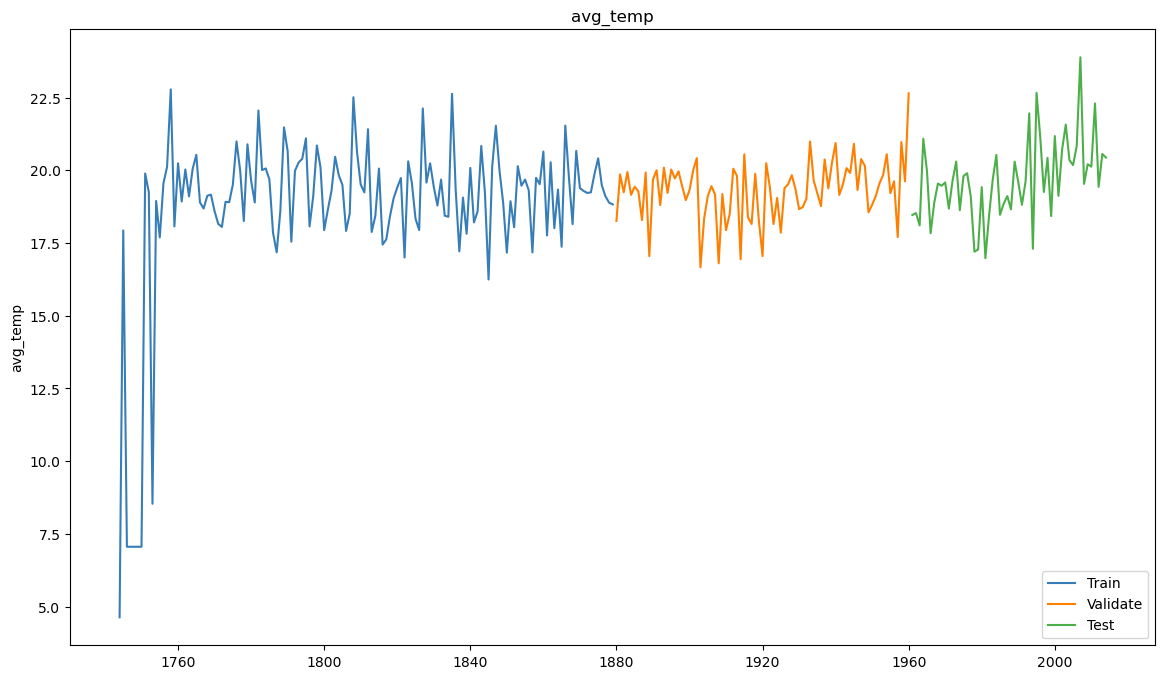

In [26]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(validate[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [27]:
def make_baseline_predictions(avg_temp):
    yhat_df = pd.DataFrame({'avg_temp': avg_temp},
                          index=validate.index)
    return yhat_df

In [28]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(mean_squared_error(validate[target_var], yhat_df[target_var], squared=False),3)
    return rmse

In [29]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, f'-- RMSE: {rmse:.3f}')
    plt.show()

In [30]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [31]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Least Observed Value

In [32]:
col = 'avg_temp'
target_variable  = 'avg_temp'

In [33]:
train['avg_temp'][-1:][0]

18.827

In [34]:
last_avg_temp = round(train['avg_temp'][-1:][0],2)
last_avg_temp

18.83

In [35]:
yhat_df = make_baseline_predictions(last_avg_temp)
yhat_df.head()

,avg_temp
date,
1879-12-31,18.83
1880-12-31,18.83
1881-12-31,18.83
1882-12-31,18.83
1883-12-31,18.83


avg_temp -- RMSE: 1.132


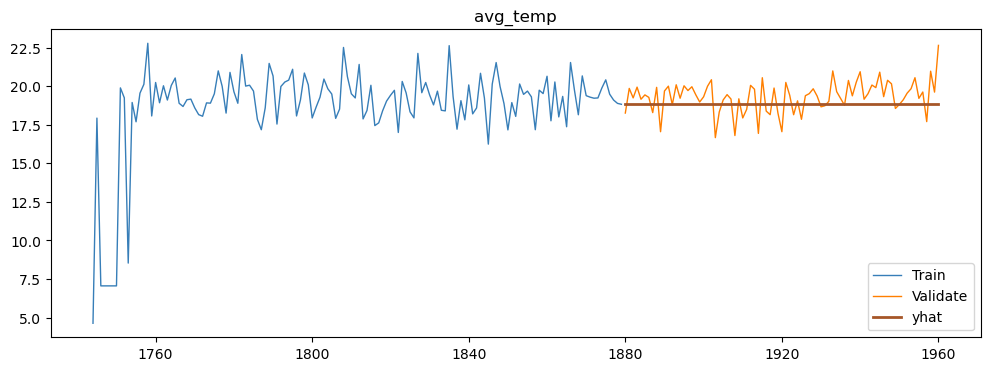

In [36]:
plot_and_eval(col)

In [37]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,1.132


### Simple Average

In [38]:
avg_temp = round(train['avg_temp'].mean(),2)
avg_temp

18.7

In [39]:
yhat_df = make_baseline_predictions(avg_temp)
yhat_df.head()

,avg_temp
date,
1879-12-31,18.7
1880-12-31,18.7
1881-12-31,18.7
1882-12-31,18.7
1883-12-31,18.7


avg_temp -- RMSE: 1.194


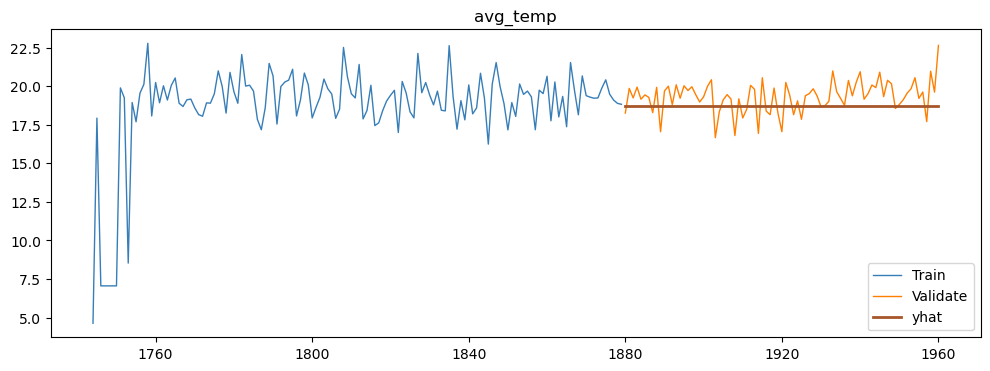

In [40]:
plot_and_eval(col)

In [41]:
eval_df = append_eval_df(model_type = 'simple_average', target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,1.132
1,simple_average,avg_temp,1.194


#### Moving Average

In [42]:
period=5
train['avg_temp'].rolling(period).mean()

date
1743-12-31        NaN
1744-12-31        NaN
1745-12-31        NaN
1746-12-31        NaN
1747-12-31     8.7488
               ...   
1874-12-31    19.6082
1875-12-31    19.6466
1876-12-31    19.6230
1877-12-31    19.5524
1878-12-31    19.3418
Freq: A-DEC, Name: avg_temp, Length: 136, dtype: float64

In [43]:
train['avg_temp'].rolling(period).mean()[-1]

19.3418

In [44]:
rolling_avg_temp = round(train['avg_temp'].rolling(period).mean()[-1],2)
rolling_avg_temp

19.34

In [45]:
yhat_df = make_baseline_predictions(rolling_avg_temp)
yhat_df

,avg_temp
date,
1879-12-31,19.34
1880-12-31,19.34
1881-12-31,19.34
1882-12-31,19.34
1883-12-31,19.34
...,...
1955-12-31,19.34
1956-12-31,19.34
1957-12-31,19.34


avg_temp -- RMSE: 1.023


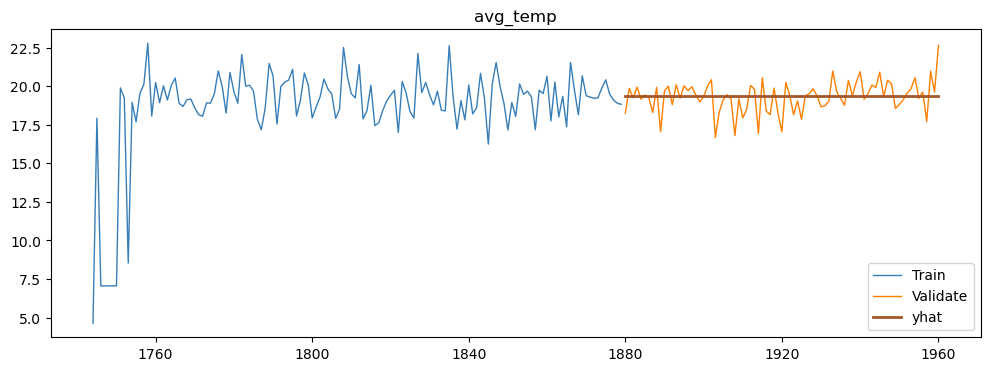

In [46]:
plot_and_eval(col)

In [47]:
eval_df = append_eval_df(model_type = '5_year_moving_avg', target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,1.132
1,simple_average,avg_temp,1.194
2,5_year_moving_avg,avg_temp,1.023


In [48]:
train.isnull().sum()

avg_temp    0
dtype: int64

#### Holt's Linear Trend Model

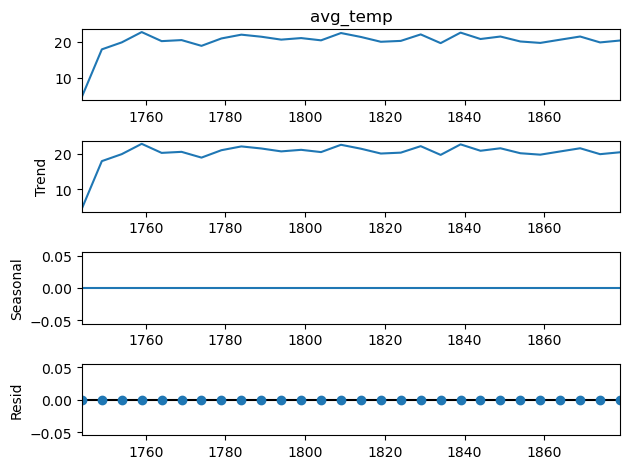

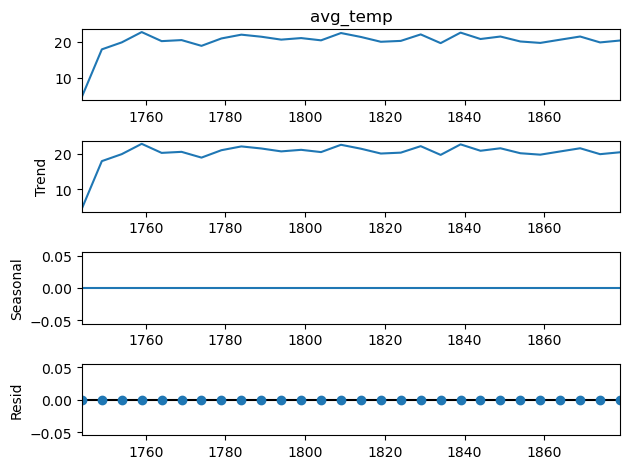

In [49]:
sm.tsa.seasonal_decompose(train[col].resample('5y').max()).plot()
# sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()

In [50]:

# create our Holt Object
model = Holt(train[col], exponential=False, damped=True)
# fit the Holt object
model = model.fit(optimized=True)
yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
yhat_df[col] = round(yhat_values, 2)
yhat_df.head()

,avg_temp
date,
1879-12-31,19.43
1880-12-31,19.43
1881-12-31,19.43
1882-12-31,19.43
1883-12-31,19.43


avg_temp -- RMSE: 1.029


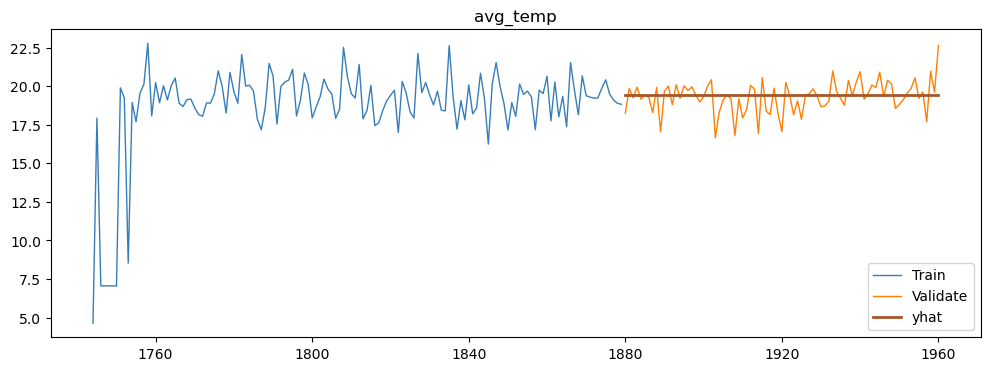

In [51]:
plot_and_eval(col)

In [52]:
eval_df = append_eval_df(model_type = 'holts_optimized', target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,1.132
1,simple_average,avg_temp,1.194
2,5_year_moving_avg,avg_temp,1.023
3,holts_optimized,avg_temp,1.029


In [53]:
train.shape, validate.shape, test.shape

((136, 1), (81, 1), (54, 1))

### Evaluation of model

In [56]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
2,5_year_moving_avg,avg_temp,1.023
3,holts_optimized,avg_temp,1.029
0,last_observed_value,avg_temp,1.132
1,simple_average,avg_temp,1.194


### Performance on Test

In [57]:
rolling_avg_temp = round(validate['avg_temp'].rolling(period).mean()[-1],2)
rolling_avg_temp

20.11

In [86]:
yhat_df = pd.DataFrame({'avg_temp': rolling_avg_temp},
                          index=test.index)

In [88]:
yhat_df.head()

,avg_temp
date,
1960-12-31,20.11
1961-12-31,20.11
1962-12-31,20.11
1963-12-31,20.11
1964-12-31,20.11


In [90]:
yhat_df.shape

(54, 1)

In [93]:
rmse = round(mean_squared_error(test['avg_temp'], yhat_df['avg_temp'], squared=False),3)
rmse

1.434

In [ ]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

RMSE-avg_temp: 1.434


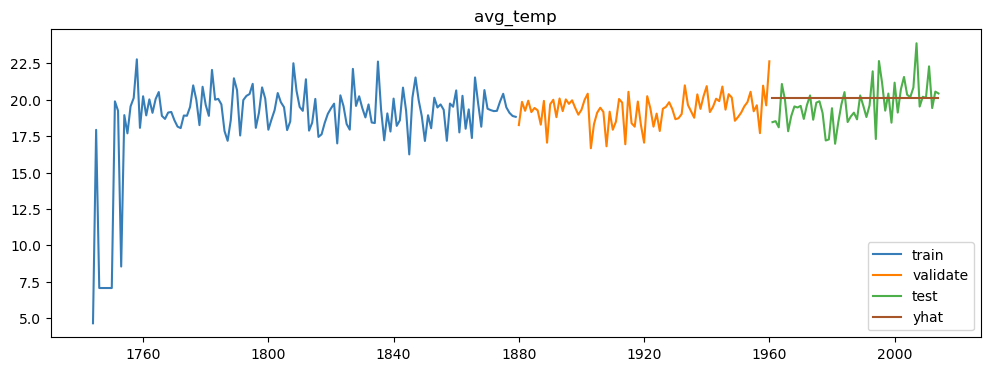

In [96]:
print(f'RMSE-avg_temp: {rmse}')
final_plot('avg_temp')